In [34]:
library(tidymodels)
library(tidyverse)
library(treesnip) # Catboost§
library(lubridate)
library(broom)
library(scales)

# Chart Theme
theme_set(theme_bw() +
          theme(plot.title = element_text(size = 14, face = "bold"),
                plot.subtitle = element_text(size = 10, face = "italic",
                                             colour = "grey50")))

# Loading Data
data <- read_csv("insurance.csv") %>% 
      select(-index)


Rows: 1338 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (5): index, age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [35]:
head(data)

age,sex,bmi,children,smoker,region,charges
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
19,female,27.900,0,yes,southwest,16884.924
18,male,33.770,1,no,southeast,1725.552
28,male,33.000,3,no,southeast,4449.462
33,male,22.705,0,no,northwest,21984.471
32,male,28.880,0,no,northwest,3866.855
31,female,25.740,0,no,southeast,3756.622


In [36]:
nrow(data)
ncol(data)

[1] 1338

[1] 7

## Implementing XGBoost in R

In [46]:
dt_train <- read_csv("train.csv")
dt_test <- read_csv("test.csv")

Rows: 1003 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 335 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [47]:
xg_rf <- recipe(charges ~ ., data = dt_train) %>% 
    step_mutate(children = factor(children)) %>% 
    step_normalize(all_numeric_predictors()) %>% 
    step_dummy(all_nominal_predictors())

In [48]:
xg_wflow <- workflow() %>% 
    add_recipe(xg_rf) %>% 
    add_model(
        boost_tree() %>% 
            set_mode("regression") %>% 
            set_engine("xgboost")
    ) %>% 
    fit(dt_train)

In [49]:
eval_metrics <- metric_set(rsq, mae, rmse, mape)

In [50]:
xg_fit %>% 
    augment(dt_test) %>% 
    eval_metrics(truth = charges, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.916576
mae,standard,1829.003257
rmse,standard,3579.818810
mape,standard,22.155421


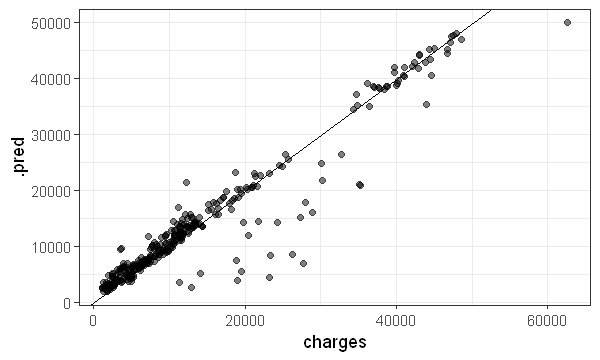

In [45]:
options(repr.plot.width=5, repr.plot.height=3)

xg_fit %>% 
    augment(dt_test) %>% 
    ggplot(aes(charges, .pred)) +
    geom_point(alpha = 0.5) +
    geom_abline()